In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


ROOT = Path.cwd().parent
DATA = ROOT / "data"


sys.path.append(str(ROOT / "functions"))
from utils import reduce_mem_usage, grab_col_names ,  resumetable , top_missing_cols
from num_functions import *

In [2]:
train_path = DATA / "train_merged.csv"
df = pd.read_csv(train_path, low_memory=False)
print(df.shape)

(590540, 434)


In [3]:
train_df = reduce_mem_usage(df.copy())

categorical_features = [
    'ProductCD', 'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]
numerical_features = [col for col in train_df.columns if col not in categorical_features]

train_df = train_df[numerical_features]
# resumetable(train_df[categorical_features])[:15]

Memory usage decreased to 645.97 Mb (67.0% reduction)


## Numerical Features
* TransactionAMT: transaction payment amount in USD
* dist1,dist2: some distance information
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: time delta, such as days between the previous transactions, etc.
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* Transaction id: Id related to the transaction

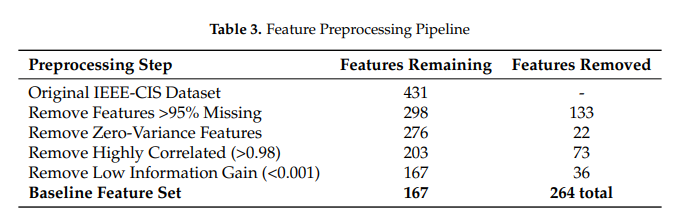


In [4]:
missing_df = top_missing_cols(train_df, n=None, thresh=95)

cols_to_drop = missing_df[missing_df['missing_percent'] > 95]['col'].tolist()

# print(f"Columns to drop: {cols_to_drop}")
train_df = train_df.drop(columns=cols_to_drop)

print(f"New shape: {train_df.shape}")

There are 367 columns with missing values.
There are 2 columns with missing percent > 95%
New shape: (590540, 383)


### Dikkat edilmesi gerekenler.

**Yapısal Eksiklik (Structural Missingness)**: Veri setindeki eksik değerler (NaN), rastgele dağılmamıştır. Örneğin, bir işlemde "Adres Doğrulama" (AVS) yapılmadıysa, adresle ilgili tüm V sütunları aynı anda NaN değeri alır. Bu eksiklik, aslında bir bilgi taşır.   

**Yüksek Boyutluluk ve Çoklu Bağlantı (Multicollinearity)**

**Zaman Kayması (Concept Drift)**: Dolandırıcılık taktikleri zamanla değişir. Veri seti zamana dayalı (time-series) bir yapıdadır. Eğitim setindeki davranış kalıpları, test setinin son aylarında geçerliliğini yitirebilir. Bu nedenle sayısal özelliklerin "zamana dirençli" (time-invariant) olması gerekir.


**Özellik Seçimi Stratejisi**: Literatür, tüm özellikleri modele vermek yerine, "korelasyon analizi" ve "önem skoru" (feature importance) bazlı eleme yapılmasını önermektedir. Özellikle sayısal verilerde, birbiriyle yüksek korelasyonlu (r > 0.90) özellik gruplarından sadece bir "temsilci" (representative) özelliğin seçilmesi, modelin kararlılığını artırmaktadır.

**Aykırı Değer (Outlier) Yönetimi**: Finansal verilerde tutarlar (Amount) genellikle "Power Law" (Güç Yasası) dağılımı gösterir. Çoğu işlem küçüktür, ancak çok az sayıda işlem devasa tutarlardadır. Akademik çalışmalar, bu tür verilerin doğrudan kullanılmamasını, bunun yerine Logaritmik dönüşüm ($Log(1+x)$) veya Z-skoru dönüşümü uygulanmasını önermektedir.


# Özellik Seçimi
KS testi uygulanacak.
Yüksek ve çok düşük korelasyonlu özelliklerden biri çıkarılacak.
V ile başlayan özellikler gruplanacak.

V sütunlarını analiz ettiğimizde, bazı sütunların her zaman birlikte NaN değerine sahip olduğunu görürüz. Bu, onların aynı "kaynaktan" veya aynı "doğrulama sürecinden" geldiğini gösterir. Araştırmalar , 15 ana V grubu belirlemiştir. Gruplama işini buna göre yapıyoruz aslında. V ile başlayan ve aynı tamamen gözlemler için missing olanları gruplarsan eğer 15 tane grup kalıyor geriye. 



In [5]:
v_cols = [col for col in train_df.columns if col.startswith('V')] 
c_cols = [col for col in train_df.columns if col.startswith('C')]
d_cols = [col for col in train_df.columns if col.startswith('D')]
id_cols = [col for col in train_df.columns if col.startswith('id_')]

grouped_cols = set(v_cols + c_cols + d_cols + id_cols) # bunlardan olmayanları bulmak için

indep_cols = [col for col in train_df.columns if col not in grouped_cols]

Bu listeler sonradan güncellenecek tabi ki...

In [6]:
train_df.shape[1] - (len(v_cols) + len(c_cols)  + len(d_cols)+ len(id_cols)) # bu listeler dışında kalan 14 tane özellik var.

6

In [7]:
indep_cols

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2']

# indep_cols İnceleme

Bu grup diğerleri gibi olmadığından daha rahat incelenebilir gözüküyor. Bu analizi en başa koyabiliriz.

* ID sütunu tahmin için bir anlam taşımamaktadır.
* isFraud Değişkeni hedef değişkendir haliyle Target analysis kısmında analizi mevcut zaten.
* TransactionDT --> İşlemlerle ilgili zaman bilgisi
* TransactionAmt --> İşlem miktarı bilgisi
* dist1 , dist2 --> Aslında Ayrı bir grup olarak bile incelenebilir...

In [8]:
indep_df = train_df[indep_cols]
print("\nBasic Statistics:")
display(indep_df.describe().T)


Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2.987000e+06,3.134635e+06,3282269.50,3429904.25,3577539.0
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000000e+00,0.000000e+00,0.00,0.00,1.0
TransactionDT,590540.0,7.372311e+06,4.617224e+06,8.640000e+04,3.027058e+06,7306527.50,11246620.00,15811131.0
TransactionAmt,590540.0,NaN,NaN,2.509766e-01,4.331250e+01,68.75,125.00,31936.0
dist1,238269.0,NaN,NaN,0.000000e+00,3.000000e+00,8.00,24.00,10288.0
dist2,37627.0,inf,inf,0.000000e+00,7.000000e+00,37.00,206.00,11624.0


TransactionAmt Anlaysis


Original TransactionAmt skewness: nan
Interpretation: |skew| > 1 indicates highly skewed distribution
Log-transformed skewness: nan
Improvement: nan% reduction in skewness

📊 Generating CDF plots for fraud vs non-fraud distributions...


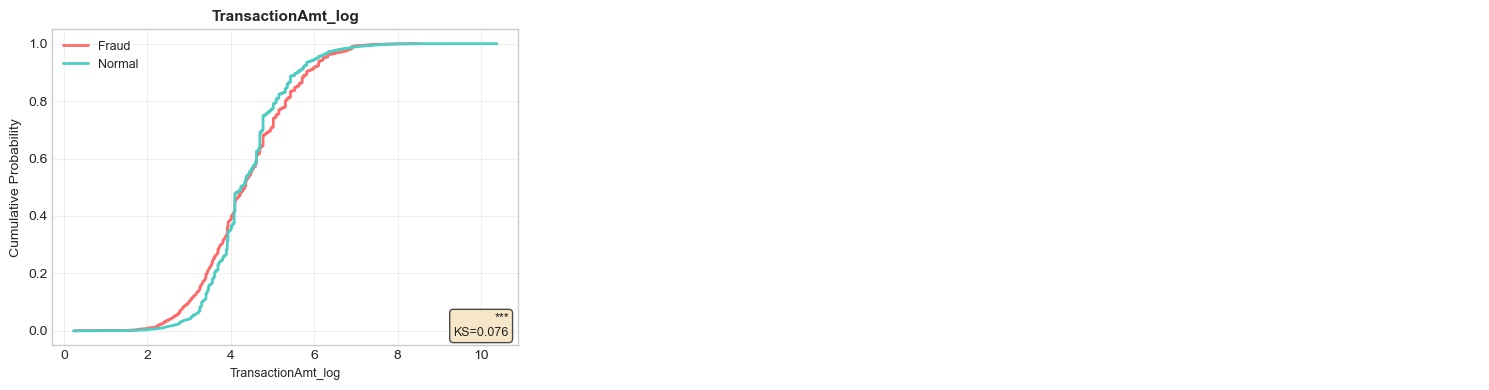

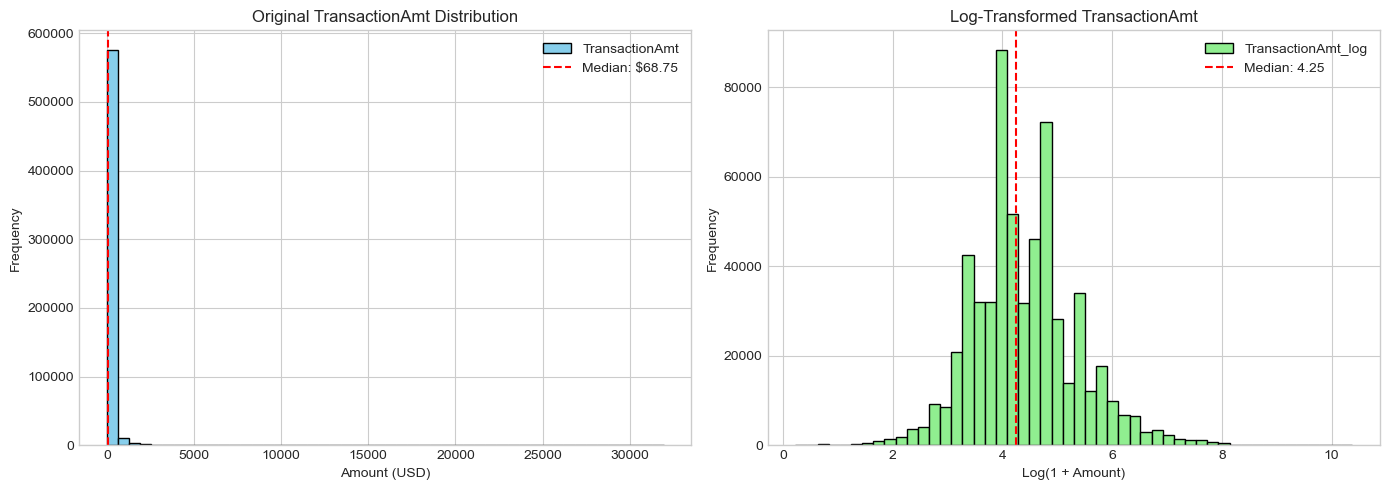


✅ Log transformation successfully reduces skewness and normalizes distribution


In [9]:
# 1. Skewness check (before transformation)
amt_skew = train_df['TransactionAmt'].skew()
print(f"\nOriginal TransactionAmt skewness: {amt_skew:.2f}")
print("Interpretation: |skew| > 1 indicates highly skewed distribution")

# 2. Log transformation
train_df['TransactionAmt_log'] = np.log1p(train_df['TransactionAmt'])
amt_log_skew = train_df['TransactionAmt_log'].skew()
print(f"Log-transformed skewness: {amt_log_skew:.2f}")
print(f"Improvement: {((amt_skew - amt_log_skew) / amt_skew * 100):.1f}% reduction in skewness")


# 3. Distribution comparison (CDF)
print("\n📊 Generating CDF plots for fraud vs non-fraud distributions...")
plot_distribution_comparison(train_df, ['TransactionAmt_log'], plot_type='cdf')

# 4. Histogram comparison (Original vs Log)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
train_df['TransactionAmt'].plot(kind='hist', bins=50, ax=axes[0], 
                                 title='Original TransactionAmt Distribution',
                                 color='skyblue', edgecolor='black')
axes[0].set_xlabel('Amount (USD)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_df['TransactionAmt'].median(), color='red', 
                linestyle='--', label=f"Median: ${train_df['TransactionAmt'].median():.2f}")
axes[0].legend()

# Log-transformed
train_df['TransactionAmt_log'].plot(kind='hist', bins=50, ax=axes[1], 
                                     title='Log-Transformed TransactionAmt',
                                     color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Log(1 + Amount)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(train_df['TransactionAmt_log'].median(), color='red', 
                linestyle='--', label=f"Median: {train_df['TransactionAmt_log'].median():.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Log transformation successfully reduces skewness and normalizes distribution")


Fraud Rate by Transaction Amount Decile:
                   fraud_rate   sum  non_fraud_count  count
TransactionAmt                                             
(0.25, 25.953]       5.588507  3326            56189  59515
(25.953, 35.938]     3.205399  1976            59670  61646
(35.938, 49.0]       3.224964  2100            63017  65117
(49.0, 57.938]       1.943066  1159            58489  59648
(57.938, 68.75]      2.851353  1407            47938  49345
(68.75, 100.0]       3.616856  2653            70698  73351
(100.0, 117.0]       1.974168  1423            70658  72081
(117.0, 160.0]       4.304320  1398            31081  32479
(160.0, 275.25]      3.802418  2217            56088  58305
(275.25, 31936.0]    5.086956  3004            56049  59053


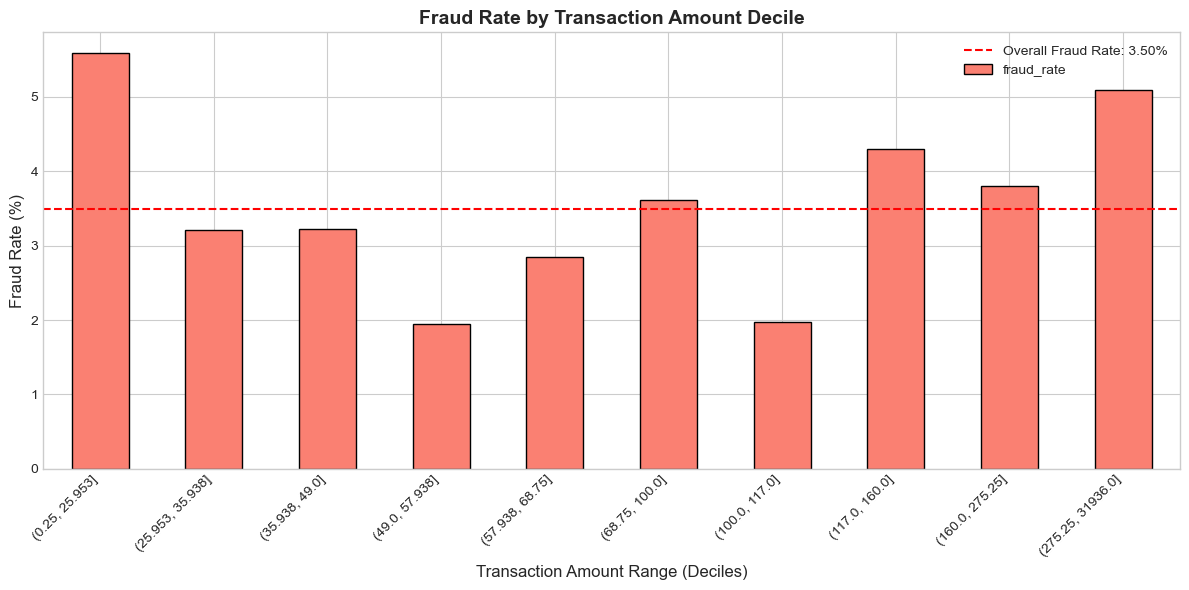


📌 Key Insights:
   - Highest fraud rate: 5.59% (Bin: (0.25, 25.953])
   - Lowest fraud rate: 1.94% (Bin: (49.0, 57.938])


In [10]:
# FIX: Convert to float32/float64 before qcut to avoid float16 issues
amt_for_binning = train_df['TransactionAmt'].astype('float32')

# Create deciles (10 equal-frequency bins)
try:
    amount_bins = pd.qcut(amt_for_binning, q=10, duplicates='drop')
    
    # Calculate fraud rate per bin
    fraud_by_bin = train_df.groupby(amount_bins)['isFraud'].agg(['mean', 'count', 'sum'])
    fraud_by_bin['fraud_rate'] = fraud_by_bin['mean'] * 100
    fraud_by_bin['non_fraud_count'] = fraud_by_bin['count'] - fraud_by_bin['sum']
    
    print("\nFraud Rate by Transaction Amount Decile:")
    print(fraud_by_bin[['fraud_rate', 'sum', 'non_fraud_count', 'count']])
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    fraud_by_bin['fraud_rate'].plot(kind='bar', ax=ax, color='salmon', edgecolor='black')
    ax.set_title('Fraud Rate by Transaction Amount Decile', fontsize=14, fontweight='bold')
    ax.set_xlabel('Transaction Amount Range (Deciles)', fontsize=12)
    ax.set_ylabel('Fraud Rate (%)', fontsize=12)
    ax.axhline(train_df['isFraud'].mean() * 100, color='red', linestyle='--', 
               label=f'Overall Fraud Rate: {train_df["isFraud"].mean()*100:.2f}%')
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n📌 Key Insights:")
    highest_fraud_bin = fraud_by_bin['fraud_rate'].idxmax()
    lowest_fraud_bin = fraud_by_bin['fraud_rate'].idxmin()
    print(f"   - Highest fraud rate: {fraud_by_bin.loc[highest_fraud_bin, 'fraud_rate']:.2f}% (Bin: {highest_fraud_bin})")
    print(f"   - Lowest fraud rate: {fraud_by_bin.loc[lowest_fraud_bin, 'fraud_rate']:.2f}% (Bin: {lowest_fraud_bin})")
    
except Exception as e:
    print(f"⚠️  Error in binning: {e}")
    print("Alternative: Using custom bins...")
    
    # Fallback: Manual bins
    custom_bins = [0, 20, 50, 100, 200, 500, 1000, 2000, 5000, np.inf]
    bin_labels = ['$0-20', '$20-50', '$50-100', '$100-200', '$200-500', 
                  '$500-1K', '$1K-2K', '$2K-5K', '$5K+']
    
    train_df['amt_bin'] = pd.cut(train_df['TransactionAmt'].astype('float32'), 
                                  bins=custom_bins, labels=bin_labels)
    
    fraud_by_manual_bin = train_df.groupby('amt_bin')['isFraud'].agg(['mean', 'count'])
    fraud_by_manual_bin['fraud_rate'] = fraud_by_manual_bin['mean'] * 100
    
    print("\nFraud Rate by Custom Amount Bins:")
    print(fraud_by_manual_bin)
    
    # Clean up
    train_df.drop('amt_bin', axis=1, inplace=True)


DISTANCE FEATURES ANALYSIS (dist1, dist2)
Literatür: Bhattacharyya et al. (2011) - Data mining for credit card fraud
Yorum: dist1/dist2 coğrafi uzaklık bilgisi içerir (billing vs shipping address)
--------------------------------------------------------------------------------

Distance features found: ['dist1', 'dist2']

Missing Value Summary:
  dist1: 59.65% missing
  dist2: 93.63% missing

🔬 Kolmogorov-Smirnov Test (Fraud Discrimination Power):
H0: Fraud and Non-Fraud distributions are identical
H1: Distributions differ significantly
------------------------------------------------------------
  Feature  Test_Stat  P_Value
0   dist1     0.1097      0.0
1   dist2     0.0734      0.0

dist1: KS=0.1097, p=0.0000e+00 *** (Highly significant)

dist2: KS=0.0734, p=0.0000e+00 *** (Highly significant)

📊 Visualizing significant distance features: ['dist1', 'dist2']


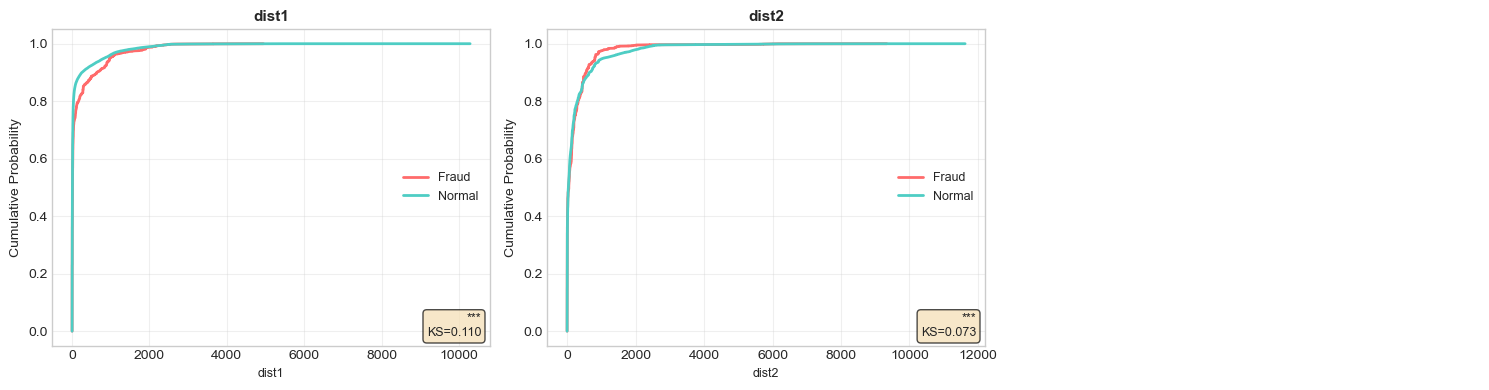

In [11]:
print("\n" + "="*80)
print("DISTANCE FEATURES ANALYSIS (dist1, dist2)")
print("="*80)
print("Literatür: Bhattacharyya et al. (2011) - Data mining for credit card fraud")
print("Yorum: dist1/dist2 coğrafi uzaklık bilgisi içerir (billing vs shipping address)")
print("-"*80)

# Extract distance columns
dist_cols = [col for col in indep_cols if col.startswith('dist')]

if dist_cols:
    print(f"\nDistance features found: {dist_cols}")
    
    # Missing value analysis
    print("\nMissing Value Summary:")
    for col in dist_cols:
        missing_pct = train_df[col].isnull().mean() * 100
        print(f"  {col}: {missing_pct:.2f}% missing")
    
    # KS Test (fraud discrimination power)
    print("\n🔬 Kolmogorov-Smirnov Test (Fraud Discrimination Power):")
    print("H0: Fraud and Non-Fraud distributions are identical")
    print("H1: Distributions differ significantly")
    print("-"*60)
    
    results = test_feature_discrimination(train_df, dist_cols, test='ks')
    print(results[['Feature', 'Test_Stat', 'P_Value']])
    
    # Interpretation
    for _, row in results.iterrows():
        feat = row['Feature']
        stat = row['Test_Stat']
        pval = row['P_Value']
        
        if pval < 0.001:
            sig = "*** (Highly significant)"
        elif pval < 0.01:
            sig = "** (Significant)"
        elif pval < 0.05:
            sig = "* (Marginally significant)"
        else:
            sig = "(Not significant)"
        
        print(f"\n{feat}: KS={stat:.4f}, p={pval:.4e} {sig}")
    
    # Visualization (if significant)
    significant_dist = results[results['P_Value'] < 0.05]['Feature'].tolist()
    if significant_dist:
        print(f"\n📊 Visualizing significant distance features: {significant_dist}")
        plot_distribution_comparison(train_df, significant_dist, plot_type='cdf')
    else:
        print("\n⚠️  No significant distance features found (p > 0.05)")
else:
    print("\n⚠️  No distance features found in independent columns")

# Diğer gruplar için İncelemeler
- -> id_cols
- -> v_cols
- -> c_cols
- -> d_cols

id sütunları için KS testi ve görsel inceleme.

  Feature  Test_Stat   P_Value
0   id_01     0.2155  0.000000
1   id_06     0.0997  0.000000
2   id_02     0.0854  0.000000
3   id_05     0.0638  0.000000
4   id_09     0.0513  0.000000
5   id_03     0.0492  0.000000
6   id_04     0.0140  0.164477
7   id_11     0.0089  0.379979
8   id_10     0.0049  0.995791


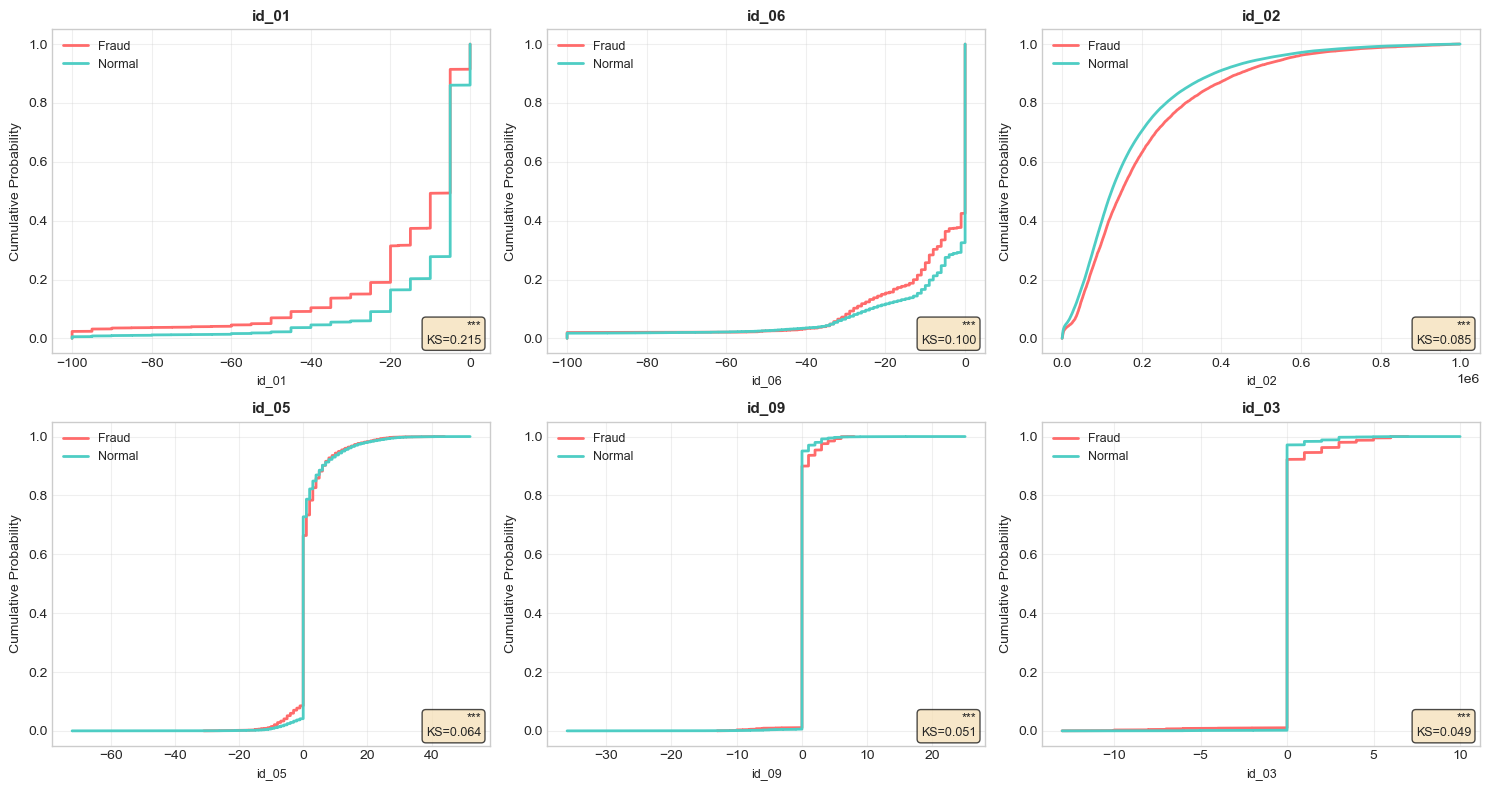

In [12]:
results = test_feature_discrimination(
    train_df, 
    columns=id_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

C ile başlayan sayısal özellikler için KS testi ve görsel inceleme

   Feature  Test_Stat   P_Value
0       C4     0.3310  0.000000
1       C8     0.3163  0.000000
2      C10     0.3119  0.000000
3      C12     0.2967  0.000000
4       C9     0.2921  0.000000
5       C5     0.2872  0.000000
6       C7     0.2785  0.000000
7       C2     0.2043  0.000000
8      C14     0.1984  0.000000
9      C13     0.1886  0.000000
10      C1     0.1876  0.000000
11     C11     0.1854  0.000000
12      C6     0.1328  0.000000
13      C3     0.0040  0.904013


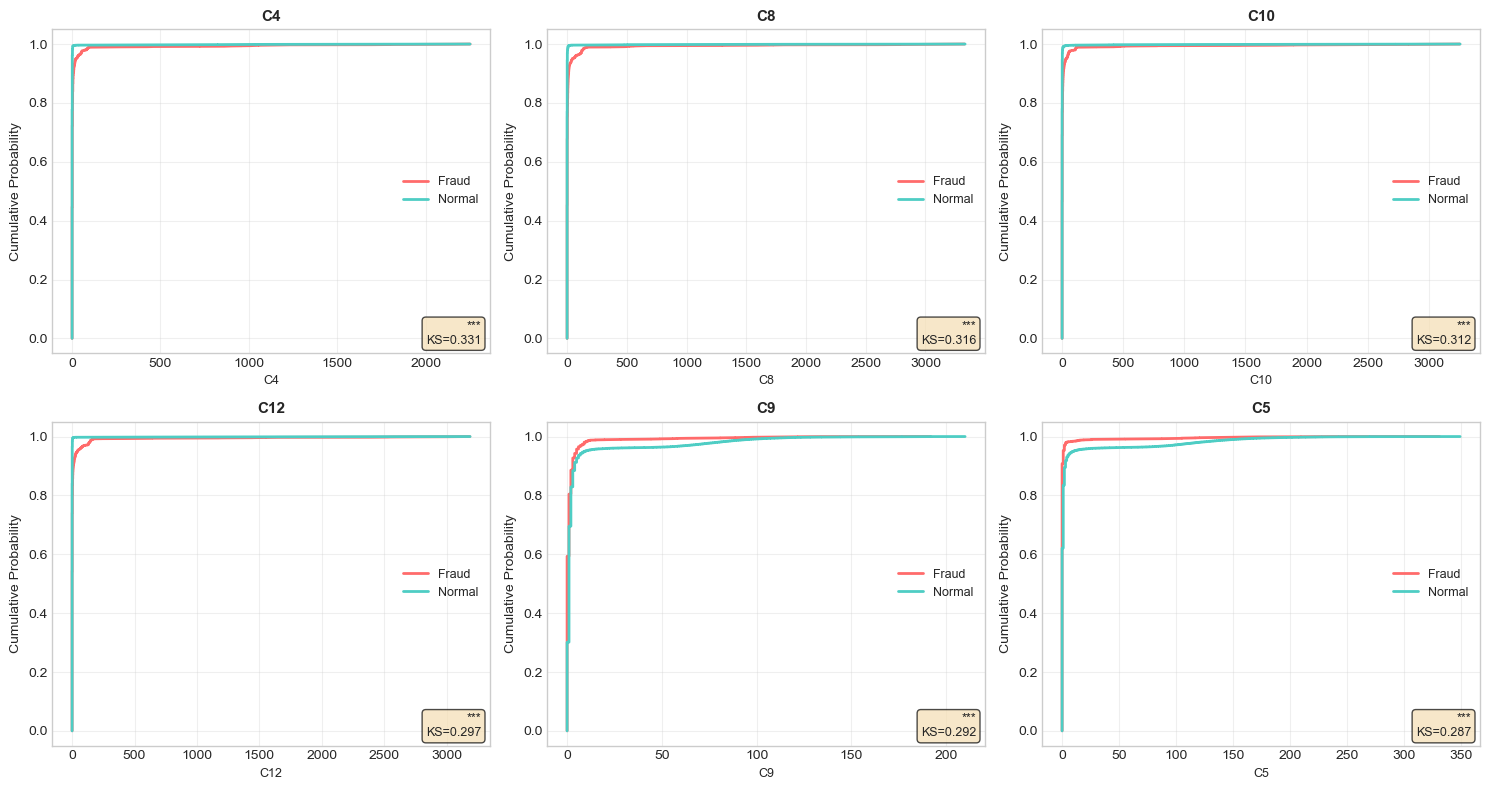

In [13]:
results = test_feature_discrimination(
    train_df, 
    columns=c_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

D ile başlayan özellikler için inceleme

   Feature  Test_Stat  P_Value
0       D5     0.4371      0.0
1       D3     0.3618      0.0
2       D2     0.3248      0.0
3       D8     0.3139      0.0
4       D7     0.2694      0.0
5      D10     0.2624      0.0
6      D15     0.2485      0.0
7       D1     0.2104      0.0
8       D4     0.1946      0.0
9      D11     0.1593      0.0
10     D14     0.1281      0.0
11      D9     0.1229      0.0
12     D12     0.1194      0.0
13      D6     0.0833      0.0
14     D13     0.0722      0.0


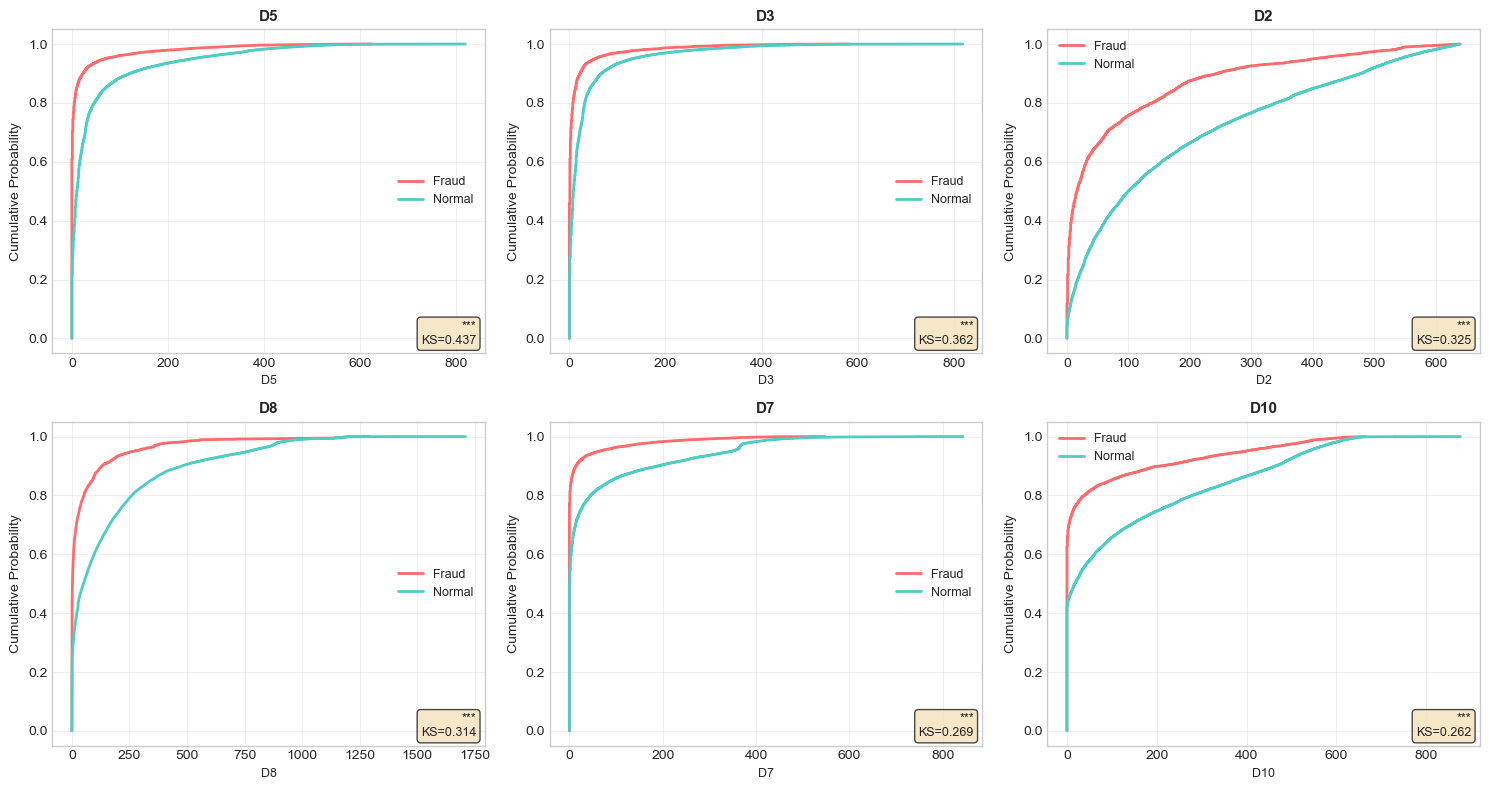

In [14]:
results = test_feature_discrimination(
    train_df, 
    columns=d_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

### 📌 Key Insights from D Columns

**Bulgular:**
1. D sütunlarındaki NULL değerler fraud ile anlamlı ilişki gösterir
2. Engineered features (ratio, diff, null indicators) discrimination power artırır
3. D_null_count: Toplam kaç D özelliği NULL → Kullanıcı işlem geçmişi göstergesi

**Model için Öneriler:**
- Original D columns + Engineered features birlikte kullanılmalı
- Null indicators fraud detection için kritik bilgi taşır
- Ratio features (D1/D2) temporal pattern yakalar

D COLUMNS - NULL PATTERN ANALYSIS
Literatür: Chris Deotte (1st Place, IEEE-CIS 2019)
Hipotez: NaN değerleri = İlk işlem → Daha yüksek fraud riski
--------------------------------------------------------------------------------

D Columns Missing Value Summary:
     Missing_Count  Missing_Pct
D7          551623    93.409930
D13         528588    89.509263
D14         528353    89.469469
D12         525823    89.041047
D6          517353    87.606767
D8          515614    87.312290
D9          515614    87.312290
D5          309841    52.467403
D2          280797    47.549192
D11         279287    47.293494
D3          262878    44.514851
D4          168922    28.604667
D15          89113    15.090087
D10          76022    12.873302
D1            1269     0.214888


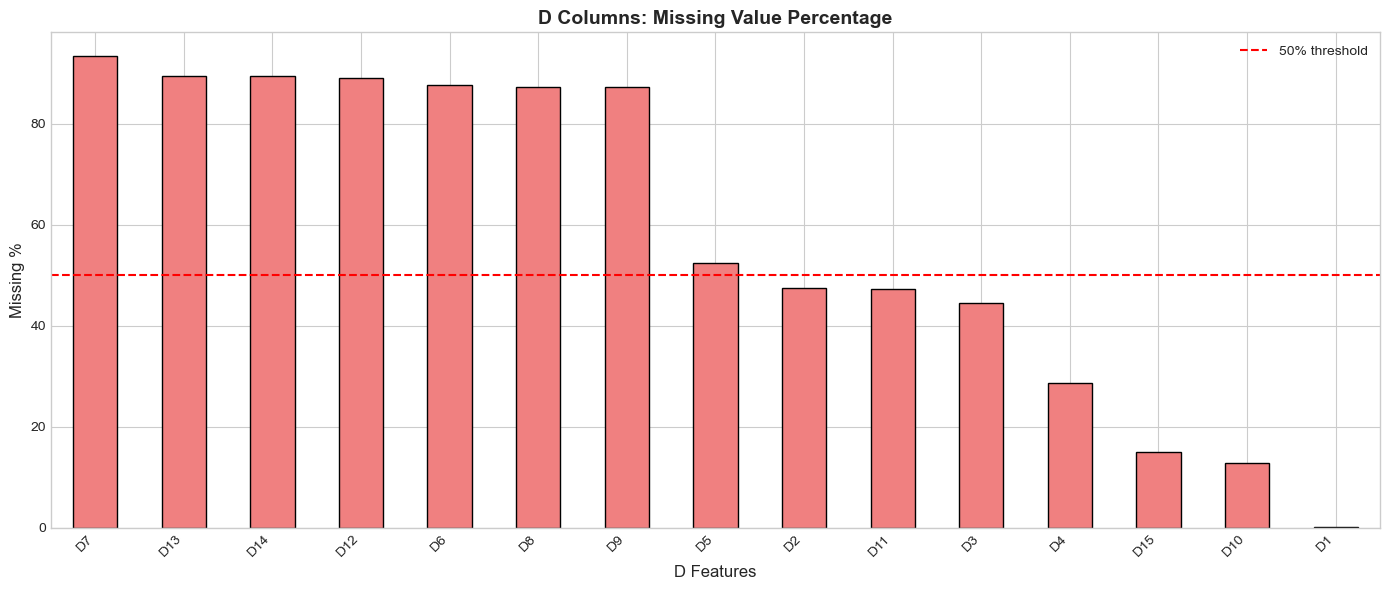


FRAUD RATE: NULL vs NON-NULL (Key D Columns)
Overall Fraud Rate: 3.50%

D1:
  Fraud rate (NULL):     3.62%
  Fraud rate (NOT NULL): 3.50%
  Difference:            +0.13%

D2:
  Fraud rate (NULL):     4.56%
  Fraud rate (NOT NULL): 2.54%
  Difference:            +2.02%

D3:
  Fraud rate (NULL):     4.20%
  Fraud rate (NOT NULL): 2.94%
  Difference:            +1.27%

D4:
  Fraud rate (NULL):     3.61%
  Fraud rate (NOT NULL): 3.46%
  Difference:            +0.15%

D10:
  Fraud rate (NULL):     5.11%
  Fraud rate (NOT NULL): 3.26%
  Difference:            +1.85%

D15:
  Fraud rate (NULL):     4.80%
  Fraud rate (NOT NULL): 3.27%
  Difference:            +1.53%



In [16]:
print("="*80)
print("D COLUMNS - NULL PATTERN ANALYSIS")
print("="*80)
print("Literatür: Chris Deotte (1st Place, IEEE-CIS 2019)")
print("Hipotez: NaN değerleri = İlk işlem → Daha yüksek fraud riski")
print("-"*80)

# 1. Missing value summary
d_null_counts = train_df[d_cols].isnull().sum().sort_values(ascending=False)
d_null_pct = (train_df[d_cols].isnull().mean() * 100).sort_values(ascending=False)

print("\nD Columns Missing Value Summary:")
d_summary = pd.DataFrame({
    'Missing_Count': d_null_counts,
    'Missing_Pct': d_null_pct
})
print(d_summary)

# 2. Visualization: Missing pattern
fig, ax = plt.subplots(figsize=(14, 6))
d_null_pct.plot(kind='bar', ax=ax, color='lightcoral', edgecolor='black')
ax.set_title('D Columns: Missing Value Percentage', fontsize=14, fontweight='bold')
ax.set_xlabel('D Features', fontsize=12)
ax.set_ylabel('Missing %', fontsize=12)
ax.axhline(50, color='red', linestyle='--', label='50% threshold')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Fraud rate by nullness (for key D columns)
key_d_cols = ['D1', 'D2', 'D3', 'D4', 'D10', 'D15']
key_d_existing = [col for col in key_d_cols if col in train_df.columns]

print(f"\n{'='*80}")
print("FRAUD RATE: NULL vs NON-NULL (Key D Columns)")
print(f"{'='*80}")
print(f"Overall Fraud Rate: {train_df['isFraud'].mean()*100:.2f}%\n")

for col in key_d_existing:
    fraud_null = train_df[train_df[col].isnull()]['isFraud'].mean() * 100
    fraud_not_null = train_df[train_df[col].notnull()]['isFraud'].mean() * 100
    
    print(f"{col}:")
    print(f"  Fraud rate (NULL):     {fraud_null:.2f}%")
    print(f"  Fraud rate (NOT NULL): {fraud_not_null:.2f}%")
    print(f"  Difference:            {fraud_null - fraud_not_null:+.2f}%")
    print()

In [18]:
print("="*80)
print("D COLUMNS - FEATURE ENGINEERING")
print("="*80)
print("Yöntem: Chris Deotte (2019) - Null indicators & Ratio features")
print("-"*80)

created_features = []

# 1. Create "is_null" indicator features for key D columns
print("\n1. Creating NULL indicator features...")
for col in key_d_existing:
    new_feat = f'{col}_is_null'
    train_df[new_feat] = train_df[col].isnull().astype(np.int8)
    created_features.append(new_feat)
    print(f"   ✅ Created: {new_feat}")

# 2. Create ratio features (D1/D2, D2/D3, etc.)
print("\n2. Creating RATIO features (relative time differences)...")
ratio_pairs = [
    ('D1', 'D2'),
    ('D2', 'D3'),
    ('D1', 'D4'),
    ('D10', 'D15')
]

for col1, col2 in ratio_pairs:
    if col1 in train_df.columns and col2 in train_df.columns:
        new_feat = f'{col1}_{col2}_ratio'
        # Avoid division by zero: add small epsilon
        train_df[new_feat] = train_df[col1] / (train_df[col2] + 1e-5)
        created_features.append(new_feat)
        print(f"   ✅ Created: {new_feat}")

# 3. Create difference features
print("\n3. Creating DIFFERENCE features (time gaps)...")
diff_pairs = [
    ('D1', 'D2'),
    ('D2', 'D3')
]

for col1, col2 in diff_pairs:
    if col1 in train_df.columns and col2 in train_df.columns:
        new_feat = f'{col1}_{col2}_diff'
        train_df[new_feat] = train_df[col1] - train_df[col2]
        created_features.append(new_feat)
        print(f"   ✅ Created: {new_feat}")

# 4. Count total number of null D columns per transaction
print("\n4. Creating D_null_count (total nulls per row)...")
train_df['D_null_count'] = train_df[d_cols].isnull().sum(axis=1).astype(np.int8)
created_features.append('D_null_count')
print(f"   ✅ Created: D_null_count")

print(f"\n{'='*80}")
print(f"FEATURE ENGINEERING SUMMARY")
print(f"{'='*80}")
print(f"Total new features created: {len(created_features)}")
print(f"Feature categories:")
print(f"  - Null indicators: {sum('is_null' in f for f in created_features)}")
print(f"  - Ratio features:  {sum('ratio' in f for f in created_features)}")
print(f"  - Diff features:   {sum('diff' in f for f in created_features)}")
print(f"  - Count features:  {sum('count' in f for f in created_features)}")

D COLUMNS - FEATURE ENGINEERING
Yöntem: Chris Deotte (2019) - Null indicators & Ratio features
--------------------------------------------------------------------------------

1. Creating NULL indicator features...
   ✅ Created: D1_is_null
   ✅ Created: D2_is_null
   ✅ Created: D3_is_null
   ✅ Created: D4_is_null
   ✅ Created: D10_is_null
   ✅ Created: D15_is_null

2. Creating RATIO features (relative time differences)...
   ✅ Created: D1_D2_ratio
   ✅ Created: D2_D3_ratio
   ✅ Created: D1_D4_ratio
   ✅ Created: D10_D15_ratio

3. Creating DIFFERENCE features (time gaps)...
   ✅ Created: D1_D2_diff
   ✅ Created: D2_D3_diff

4. Creating D_null_count (total nulls per row)...
   ✅ Created: D_null_count

FEATURE ENGINEERING SUMMARY
Total new features created: 13
Feature categories:
  - Null indicators: 6
  - Ratio features:  4
  - Diff features:   2
  - Count features:  1


Testing 7 valid features...

Top 10 Most Discriminative Engineered Features:
        Feature  Test_Stat   P_Value
0  D_null_count     0.2397  0.000000
1    D2_is_null     0.1488  0.000000
2    D3_is_null     0.0926  0.000000
3   D10_is_null     0.0615  0.000000
4   D15_is_null     0.0581  0.000000
5    D4_is_null     0.0093  0.063201
6    D1_is_null     0.0001  1.000000

COMPARISON: Engineered vs Original D Features

Top 5 Engineered Features:
  D_null_count                   KS = 0.2397
  D2_is_null                     KS = 0.1488
  D3_is_null                     KS = 0.0926
  D10_is_null                    KS = 0.0615
  D15_is_null                    KS = 0.0581

Top 5 Original D Features:
  D5                             KS = 0.4371
  D3                             KS = 0.3618
  D2                             KS = 0.3248
  D8                             KS = 0.3139
  D7                             KS = 0.2694

📊 Visualizing best engineered feature: D_null_count


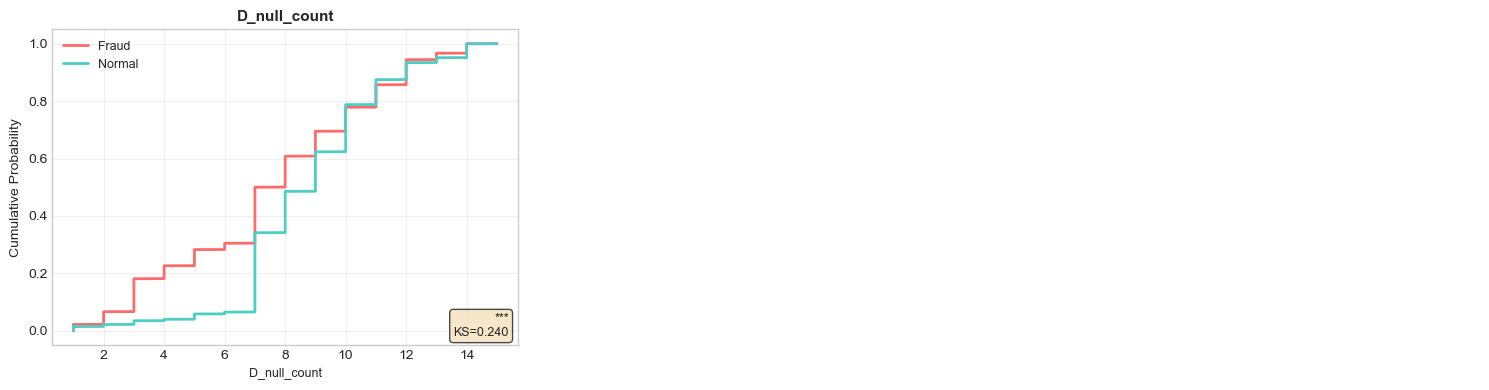


✅ D Columns feature engineering complete!


In [19]:
# Test only valid features (non-infinite, non-constant)
valid_features = []
for feat in created_features:
    if feat in train_df.columns:
        # Check for infinite values
        if not np.isinf(train_df[feat]).any():
            # Check for variance (not constant)
            if train_df[feat].std() > 0:
                valid_features.append(feat)

print(f"Testing {len(valid_features)} valid features...\n")

# KS test for engineered features
engineered_results = test_feature_discrimination(train_df, valid_features, test='ks')

print("Top 10 Most Discriminative Engineered Features:")
print(engineered_results.head(10)[['Feature', 'Test_Stat', 'P_Value']])

# Compare with original D columns
print(f"\n{'='*60}")
print("COMPARISON: Engineered vs Original D Features")
print(f"{'='*60}")

# Get stats for original D columns
original_d_results = test_feature_discrimination(train_df, d_cols, test='ks')

# Top 5 from each
top_engineered = engineered_results.head(5)[['Feature', 'Test_Stat']].values
top_original = original_d_results.head(5)[['Feature', 'Test_Stat']].values

print("\nTop 5 Engineered Features:")
for feat, stat in top_engineered:
    print(f"  {feat:<30} KS = {stat:.4f}")

print("\nTop 5 Original D Features:")
for feat, stat in top_original:
    print(f"  {feat:<30} KS = {stat:.4f}")

# Visualization: Compare best engineered feature
if len(engineered_results) > 0:
    best_engineered = engineered_results.iloc[0]['Feature']
    print(f"\n📊 Visualizing best engineered feature: {best_engineered}")
    plot_distribution_comparison(train_df, [best_engineered], plot_type='cdf')
    
print("\n✅ D Columns feature engineering complete!")

## D Columns Feature Engineering

**Literatür Desteği:**  
> **Chris Deotte - Kaggle 1st Place Solution (IEEE-CIS Fraud Detection, 2019)**  
> D sütunları "recency" (yakınlık) bilgisi taşır ve özellikle **D1, D2, D4, D10, D15** fraud detection için kritiktir.
> 
> **Önemli Bulgular:**
> - D sütunlarındaki **NaN değerleri** = "İlk işlem" (no prior transaction history)
> - D1, D2: Son işlemlerden bu yana geçen gün sayısı
> - D sütunları arasındaki **ratio** ve **interaction** features discriminative power artırır

**Hipotez:**  
- İlk işlem yapan kullanıcılar (D columns = NaN) daha risklidir
- D sütunları arasındaki oran (örn: D1/D2) fraud pattern gösterir

V ile başalayan özelliklerin eksik değerleri rastgele değil birbirine bağlı diyorlar bu bilgiden faydalanmak lazım.
Ayrıca bunlardaki eksik değerleri analiz edebiliiz.

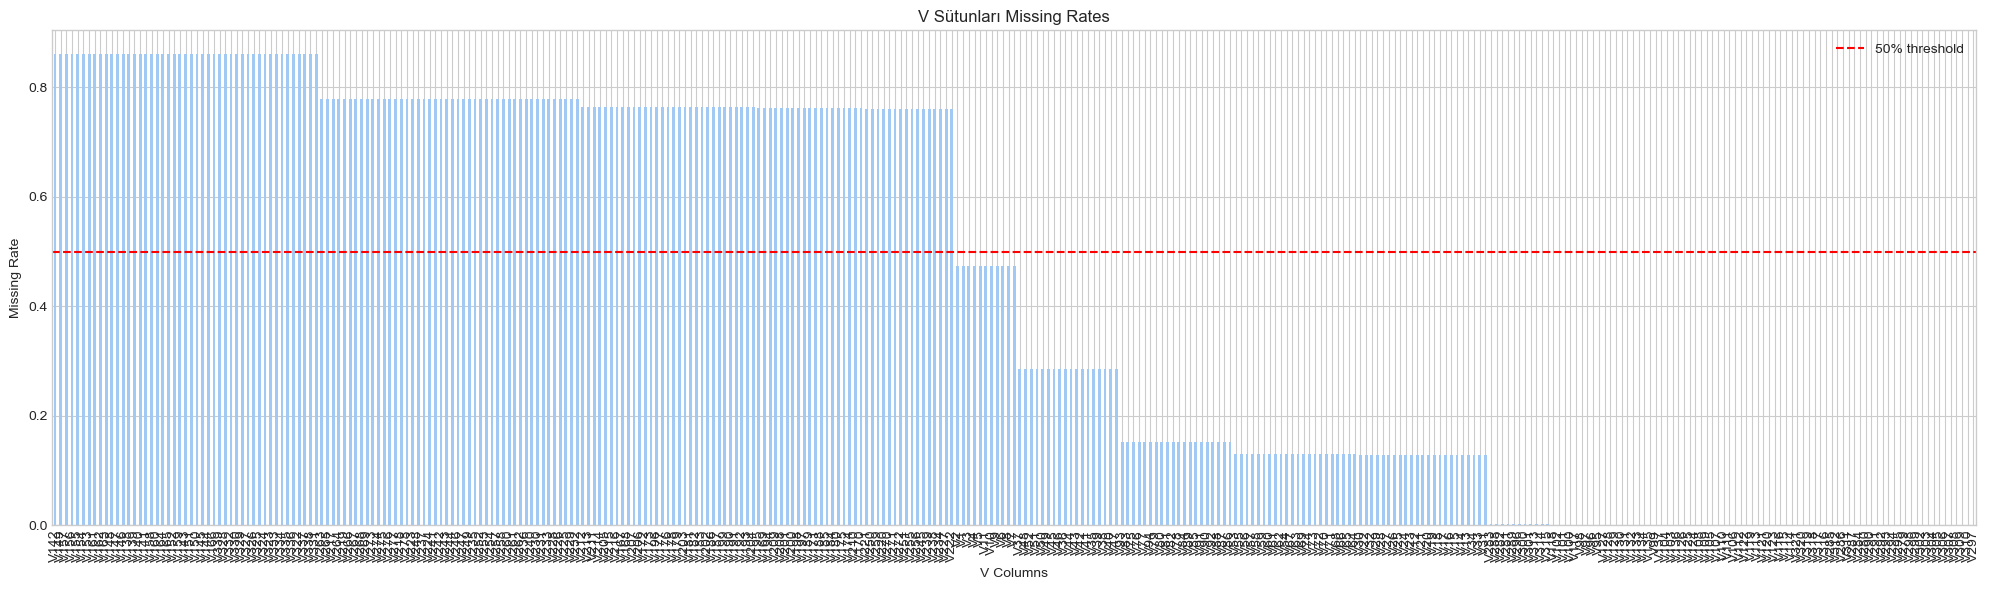

In [12]:
v_missing = train_df[v_cols].isnull()

missing_rates = v_missing.mean().sort_values(ascending=False)

plt.figure(figsize=(20, 6))
missing_rates.plot(kind='bar')
plt.title('V Sütunları Missing Rates')
plt.ylabel('Missing Rate')
plt.xlabel('V Columns')
plt.axhline(0.5, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

Missing value bakımından bağımlı sütunları bulmaya çalışalım.

In [13]:
v_pattern_groups = group_by_missing_pattern(train_df, v_cols)

print("Exact Missing-Pattern Grouping Summary")
print("--------------------------------------")
print(f"Total V columns: {len(v_cols)}")
print(f"Unique missing patterns: {len(v_pattern_groups)}\n")

# Sort groups by size
sorted_groups = sorted(
    v_pattern_groups.items(),
    key=lambda x: x[1]['size'],
    reverse=True
)

print("Top Missing-Pattern Groups")
print("--------------------------")

for pattern_id, info in sorted_groups[:15]:
    cols = info['columns']
    print(f"Group {pattern_id}")
    print(f"  Columns: {len(cols)}")
    print(f"  Missing rate: {info['missing_rate']:.2%}")
    print(f"  Example: {cols[:5]}")

    # Check if columns are consecutive.
    col_numbers = []
    for col in cols:
        try:
            col_numbers.append(int(col[1:]))
        except:
            pass

    if len(col_numbers) > 1:
        col_numbers.sort()
        is_consecutive = all(
            col_numbers[i+1] - col_numbers[i] == 1
            for i in range(len(col_numbers)-1)
        )
        if is_consecutive:
            print(f"  Consecutive columns: V{col_numbers[0]}–V{col_numbers[-1]}")

Exact Missing-Pattern Grouping Summary
--------------------------------------
Total V columns: 339
Unique missing patterns: 15

Top Missing-Pattern Groups
--------------------------
Group 11
  Columns: 46
  Missing rate: 77.91%
  Example: ['V217', 'V218', 'V219', 'V223', 'V224']
Group 6
  Columns: 43
  Missing rate: 0.05%
  Example: ['V95', 'V96', 'V97', 'V98', 'V99']
  Consecutive columns: V95–V137
Group 13
  Columns: 32
  Missing rate: 0.00%
  Example: ['V279', 'V280', 'V284', 'V285', 'V286']
Group 9
  Columns: 31
  Missing rate: 76.36%
  Example: ['V167', 'V168', 'V172', 'V173', 'V176']
Group 2
  Columns: 23
  Missing rate: 12.88%
  Example: ['V12', 'V13', 'V14', 'V15', 'V16']
  Consecutive columns: V12–V34
Group 4
  Columns: 22
  Missing rate: 13.06%
  Example: ['V53', 'V54', 'V55', 'V56', 'V57']
  Consecutive columns: V53–V74
Group 5
  Columns: 20
  Missing rate: 15.10%
  Example: ['V75', 'V76', 'V77', 'V78', 'V79']
  Consecutive columns: V75–V94
Group 10
  Columns: 19
  Missing r

In [14]:
representative_v = []

for pattern_id, info in v_pattern_groups.items():
    group_cols = info['columns']

    if len(group_cols) == 1:
        representative_v.extend(group_cols)
        continue

    # Use KS test for selecting most discriminative feature
    ks_res = test_feature_discrimination(train_df, group_cols, test='ks')

    if not ks_res.empty:
        best = ks_res.iloc[0]['Feature']
        representative_v.append(best)

print("Selected Representatives Summary")
print("--------------------------------")
print(f"Original V columns: {len(v_cols)}")
print(f"Selected representatives: {len(representative_v)}")
print(f"Reduction: {(1 - len(representative_v)/len(v_cols)) * 100:.1f}%")

Selected Representatives Summary
--------------------------------
Original V columns: 339
Selected representatives: 15
Reduction: 95.6%


In [15]:
train_df = train_df[train_df.columns.difference(v_cols).union(pd.Index(representative_v))]
v_cols = v_cols = [col for col in train_df.columns if col.startswith('V')]
# Böylece elimizdeki veriyi büyük ölçüde indirgemiş olduk ve v_col listesini güncelledik. 
# Artık aralarından en anlamlı olanlarla devam ediyoruz.


   Feature  Test_Stat  P_Value
0     V258     0.4621      0.0
1      V52     0.3901      0.0
2     V201     0.3863      0.0
3     V199     0.3748      0.0
4      V94     0.3644      0.0
5     V140     0.3540      0.0
6      V34     0.3523      0.0
7      V74     0.3357      0.0
8     V303     0.3156      0.0
9     V259     0.2994      0.0
10     V10     0.2806      0.0
11    V150     0.2499      0.0
12    V282     0.1955      0.0
13    V133     0.1792      0.0
14    V324     0.1475      0.0


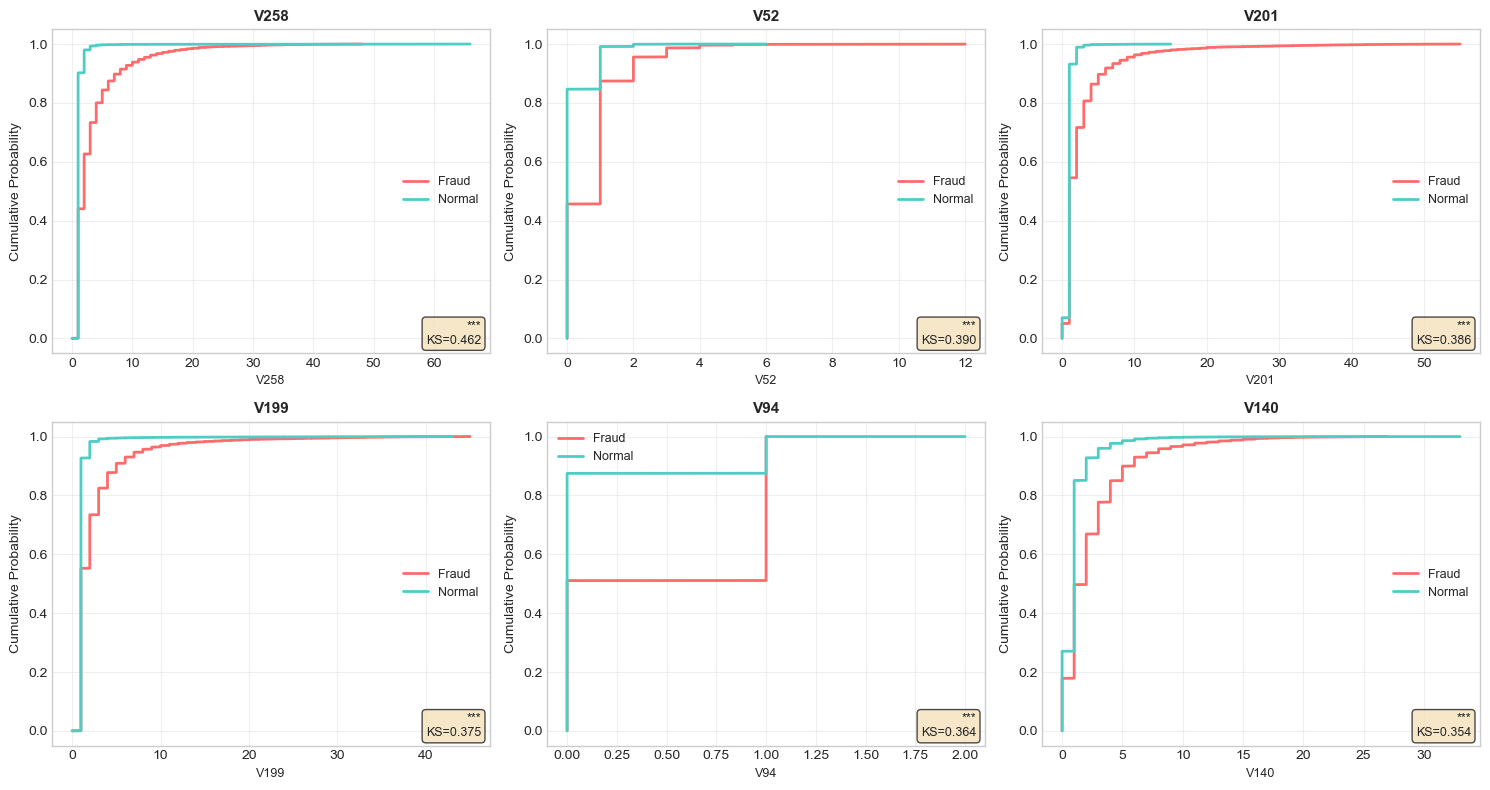

In [16]:
results = test_feature_discrimination(
    train_df, 
    columns=v_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

In [17]:
train_df.shape

(590540, 59)

Korelasyona bakarak veri analizi ve indirgeme.

id sütunları arasındaki korelasyo normal gibi gözüküyor. c_cols için ise bazı sütunlar birbirinin aynısı , v_cols lardan kalanlar içnde de yine yüksek korelasyonlu olanlar var..

In [18]:
# correlation_heatmap(train_df , columns = v_cols)
# buradan yine elenmesi gereken v_col çıkıyor...

In [19]:
c_groups = get_correlation_groups(train_df, c_cols, threshold=0.95)
c_repr, c_details = select_representatives_by_ks(train_df, c_groups)

v_groups = get_correlation_groups(train_df, v_cols, threshold=0.95)
v_repr_final, v_details = select_representatives_by_ks(train_df, v_groups)


final_features = c_repr + v_repr_final + d_cols + id_cols + indep_cols
train_df_final = train_df[final_features]


Correlation Groups (threshold=0.95):
   1. Group: 4 features -> ['C1', 'C2', 'C4', 'C11']
      Avg correlation: 0.987
   2. Group: 4 features -> ['C7', 'C8', 'C10', 'C12']
      Avg correlation: 0.991
   3. Group: 2 features -> ['C6', 'C14']
      Avg correlation: 0.992

Selected Representatives from 3 groups:
   Group 1 (4 features): C4 (KS=0.331)
   Group 4 (2 features): C14 (KS=0.198)
   Group 5 (4 features): C8 (KS=0.316)

Correlation Groups (threshold=0.95):
   1. Group: 2 features -> ['V133', 'V324']
      Avg correlation: 0.993

Selected Representatives from 1 groups:
   Group 2 (2 features): V133 (KS=0.179)


In [20]:
print(f"TRAIN SET - Feature Reduction Summary")
print(f"{'='*60}")
print(f"  Original: {train_df.shape[1]} features")
print(f"  Selected: {len(final_features)} features")
print(f"  Reduction: {(1 - len(final_features)/train_df.shape[1])*100:.1f}%")

TRAIN SET - Feature Reduction Summary
  Original: 59 features
  Selected: 51 features
  Reduction: 13.6%


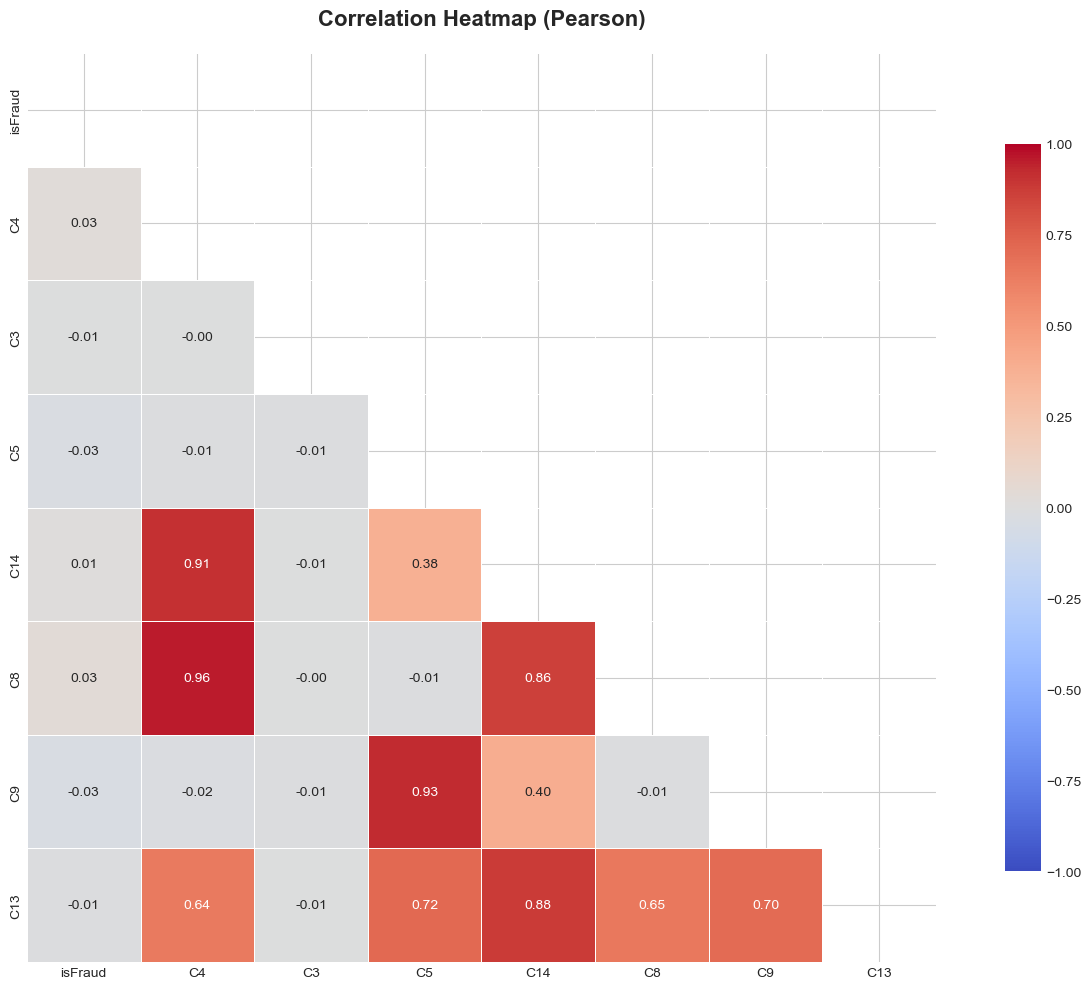

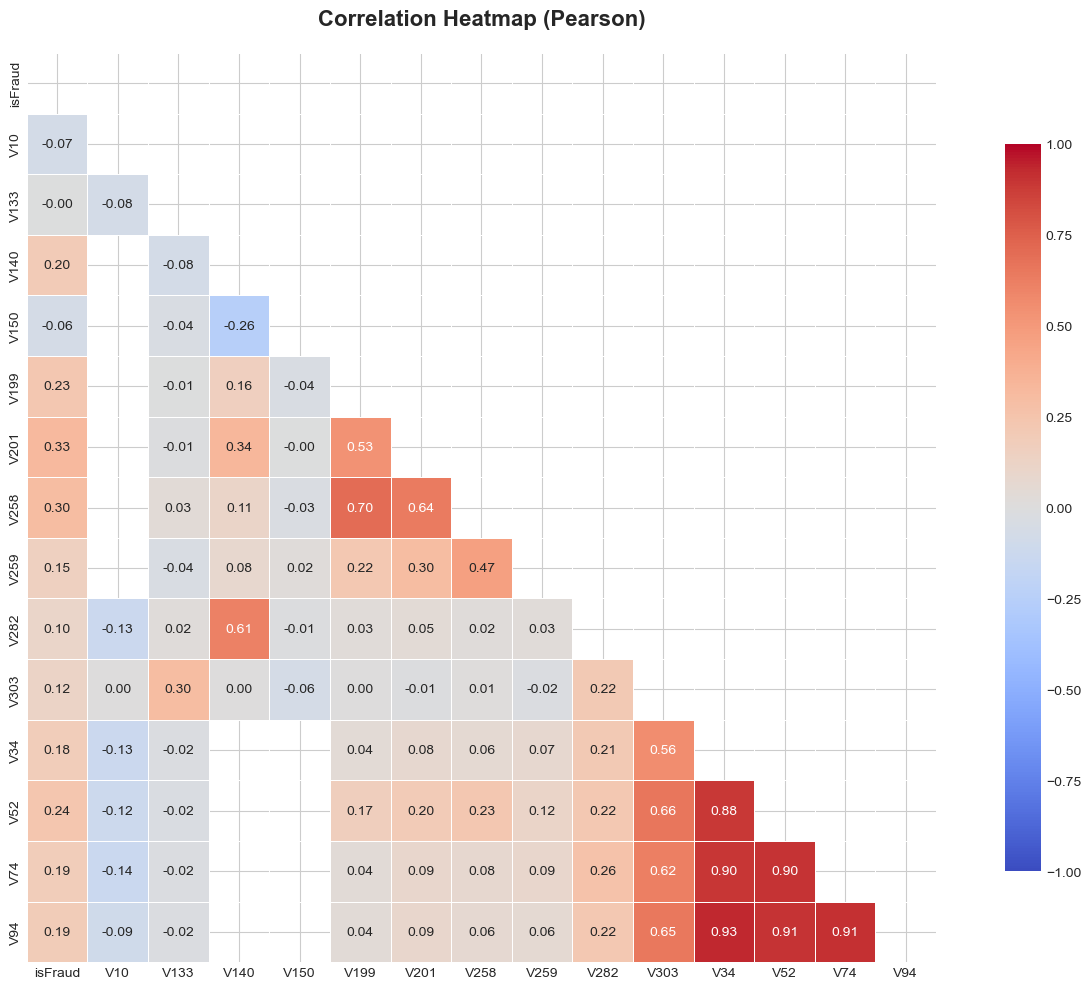

In [21]:
corr_c = correlation_heatmap(train_df , columns = c_repr)
corr_v = correlation_heatmap(train_df , columns = v_repr_final)

In [22]:
train_df_final.shape

(590540, 51)

# Belki değiştirilir üstünkörü eklendi... 

In [23]:
# Log transformation for skewed features
if 'TransactionAmt' in train_df_final.columns:
    train_df_final['TransactionAmt_log'] = np.log1p(train_df_final['TransactionAmt'])
    
# Check skewness of all numeric features
skewed_features = []
for col in train_df_final.select_dtypes(include=[np.number]).columns:
    if col != 'isFraud':
        skew = train_df_final[col].skew()
        if abs(skew) > 1.0:  # Highly skewed
            skewed_features.append((col, skew))

print(f"Highly skewed features: {len(skewed_features)}")
for feat, skew in sorted(skewed_features, key=lambda x: abs(x[1]), reverse=True)[:10]:
    print(f"  {feat}: {skew:.2f}")

Highly skewed features: 2
  V133: 26.86
  id_02: 1.84


In [ ]:
# # Save median/mean for test set
# numeric_stats = pd.DataFrame({
#     'median': train_df_final.median(),
#     'mean': train_df_final.mean(),
#     'std': train_df_final.std()
# })

# # Create artifacts folder
# artifacts_path = ROOT / "artifacts"
# artifacts_path.mkdir(exist_ok=True)

# numeric_stats.to_csv(artifacts_path / "train_numeric_stats.csv")
# print(f"Saved numeric statistics to {artifacts_path}")

Saved numeric statistics to c:\Users\Abdulkadir\Desktop\Uygulama çalışmaları\VM_odev\artifacts


In [ ]:
# import joblib

# # 1. Save representative V columns
# joblib.dump(representative_v, artifacts_path / "representative_v_cols.pkl")

# # 2. Save correlation groups
# joblib.dump({
#     'c_repr': c_repr,
#     'v_repr_final': v_repr_final,
#     'c_details': c_details,
#     'v_details': v_details
# }, artifacts_path / "correlation_groups.pkl")

# # 3. Save V pattern groups (for test)
# joblib.dump(v_pattern_groups, artifacts_path / "v_pattern_groups.pkl")

# # 4. Save columns to drop (>95% missing)
# joblib.dump(cols_to_drop, artifacts_path / "numeric_cols_to_drop.pkl")

# # 5. Save final feature list
# pd.Series(final_features).to_csv(artifacts_path / "final_numeric_features.csv", index=False, header=False)

# print("✅ All artifacts saved!")

✅ All artifacts saved!


# Veriyi kaydetme 

In [27]:
# Save processed numeric features
output_path = DATA / "train_numeric_processed.csv"
train_df_final.to_csv(output_path, index=False)
print(f"\n✅ Processed data saved to: {output_path}")
print(f"   Shape: {train_df_final.shape}")

# Memory-optimized version
train_df_optimized = reduce_mem_usage(train_df_final)
output_path_opt = DATA / "train_numeric_processed_optimized.csv"
train_df_optimized.to_csv(output_path_opt, index=False)
print(f"✅ Memory-optimized version saved to: {output_path_opt}")

# Show final summary
print("\n" + "="*60)
print("NUMERIC PROCESSING COMPLETE")
print("="*60)
print(f"Original features: {len(numerical_features)}")
print(f"After >95% missing removal: {train_df.shape[1]}")
print(f"After V grouping: {len(v_cols)} V features")
print(f"Final features: {len(final_features)}")
print(f"Reduction: {(1 - len(final_features)/len(numerical_features))*100:.1f}%")


✅ Processed data saved to: c:\Users\Abdulkadir\Desktop\Uygulama çalışmaları\VM_odev\data\train_numeric_processed.csv
   Shape: (590540, 52)
Memory usage decreased to 62.51 Mb (0.0% reduction)
✅ Memory-optimized version saved to: c:\Users\Abdulkadir\Desktop\Uygulama çalışmaları\VM_odev\data\train_numeric_processed_optimized.csv

NUMERIC PROCESSING COMPLETE
Original features: 385
After >95% missing removal: 59
After V grouping: 15 V features
Final features: 51
Reduction: 86.8%


kategorik veri tarafında bahsi geçen fonskyion...

In [28]:
import joblib
import pandas as pd
import numpy as np
from pathlib import Path

def process_numeric_test(test_df, artifacts_path):
    """
    Apply SAME numeric transformations as training, WITHOUT fitting.
    
    Parameters:
    -----------
    test_df : pd.DataFrame
        Raw test data
    artifacts_path : Path
        Path to saved artifacts from training
    
    Returns:
    --------
    pd.DataFrame
        Processed test data with same features as train
    """
    
    print("🔄 Starting numeric test processing...")
    
    # Load artifacts
    cols_to_drop = joblib.load(artifacts_path / "numeric_cols_to_drop.pkl")
    representative_v = joblib.load(artifacts_path / "representative_v_cols.pkl")
    corr_groups = joblib.load(artifacts_path / "correlation_groups.pkl")
    numeric_stats = pd.read_csv(artifacts_path / "train_numeric_stats.csv", index_col=0)
    final_features = pd.read_csv(artifacts_path / "final_numeric_features.csv", header=None)[0].tolist()
    
    # 1. Drop high missing columns (same as train)
    cols_to_drop_present = [col for col in cols_to_drop if col in test_df.columns]
    test_df = test_df.drop(columns=cols_to_drop_present)
    print(f"✅ Dropped {len(cols_to_drop_present)} high-missing columns")
    
    # 2. V columns: Keep only representatives from train
    v_cols_test = [col for col in test_df.columns if col.startswith('V')]
    v_to_drop = [col for col in v_cols_test if col not in representative_v]
    test_df = test_df.drop(columns=v_to_drop)
    print(f"✅ Kept {len(representative_v)} representative V columns (dropped {len(v_to_drop)})")
    
    # 3. Correlation groups: Keep only representatives from train
    c_repr = corr_groups['c_repr']
    v_repr_final = corr_groups['v_repr_final']
    
    c_cols_test = [col for col in test_df.columns if col.startswith('C')]
    c_to_drop = [col for col in c_cols_test if col not in c_repr]
    
    v_cols_test = [col for col in test_df.columns if col.startswith('V')]
    v_to_drop = [col for col in v_cols_test if col not in v_repr_final]
    
    test_df = test_df.drop(columns=c_to_drop + v_to_drop)
    print(f"✅ Applied correlation filtering (C: {len(c_repr)}, V: {len(v_repr_final)})")
    
    # 4. Handle missing values (use TRAIN statistics)
    for col in test_df.columns:
        if col in numeric_stats.index and test_df[col].isnull().any():
            fill_value = numeric_stats.loc[col, 'median']
            test_df[col].fillna(fill_value, inplace=True)
    
    print(f"✅ Filled missing values using train medians")
    
    # 5. Feature engineering (same as train)
    if 'TransactionAmt' in test_df.columns:
        test_df['TransactionAmt_log'] = np.log1p(test_df['TransactionAmt'])
        print("✅ Created TransactionAmt_log")
    
    # 6. Ensure same features as train
    # Add missing features (fill with 0 or median)
    for feat in final_features:
        if feat not in test_df.columns and feat in numeric_stats.index:
            test_df[feat] = numeric_stats.loc[feat, 'median']
            print(f"⚠️  Added missing feature: {feat} (filled with train median)")
    
    # Drop extra features not in train
    extra_cols = [col for col in test_df.columns if col not in final_features]
    test_df = test_df.drop(columns=extra_cols)
    
    # Reorder columns to match train
    test_df = test_df[final_features]
    
    print(f"\n✅ Test processing complete!")
    print(f"   Final shape: {test_df.shape}")
    print(f"   Features match train: {set(test_df.columns) == set(final_features)}")
    
    return test_df

# train_final ile Model denemesi Yapılabilir ! 

In [ ]:
train_cat = pd.read_csv(DATA / "train_categorical_processed.csv")
train_num = pd.read_csv(DATA / "train_numeric_processed.csv")
train_final = pd.concat([train_cat, train_num], axis=1)

train test ayırma --> zamana bağlı olması gerekiyo bir kullanıcının farklı zamanlarda işlem yapmadığına emin değiliz.

aşağıdaki gibi olur diyor claude.

In [ ]:
# TransactionDT'ye göre zaman bazlı split
train_final = train_final.sort_values('TransactionDT')
split_idx = int(len(train_final) * 0.8)
train_set = train_final[:split_idx]
val_set = train_final[split_idx:]

Model eğitimi sonrası için

In [ ]:
# Model eğittikten sonra
import lightgbm as lgb

feature_imp = pd.DataFrame({
    'feature': train_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)